## Trun to Time Series Question

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

In [3]:
# Preprocessing Data
class Datasample():
  def __init__(self,df):
    self.df=df

  def add_features(self):
    self.df['tau_lag']=self.df.groupby(self.df['group_id'])['tau'].shift(1)
    self.df['dtau']=self.df['tau_lag']-self.df['tau']
    self.df['dtau/dt']=self.df['dtau']/self.df['dt']
    self.df=self.df[['a','b','L','V0','t','dt','dtau','dtau/dt','tau']].fillna(0)
    return self.df

  def split_df(self):
    num_columns=self.df.shape[-1]
    column_indices={name: i for i, name in enumerate(self.df.columns)}

    self.df=self.df.to_numpy().reshape(-1,10000,num_columns)
    train_df, test_df=train_test_split(self.df,test_size=0.1,shuffle=False)
    train_df, val_df=train_test_split(train_df, test_size=0.22,shuffle=False)
    train_df=train_df.reshape(-1,num_columns)
    train_df=pd.DataFrame(train_df,columns=column_indices)
    val_df=val_df.reshape(-1,num_columns)
    val_df=pd.DataFrame(val_df,columns=column_indices)
    test_df=test_df.reshape(-1,num_columns)
    test_df=pd.DataFrame(test_df,columns=column_indices)
    return train_df, val_df, test_df
 # def normalization(self,train_df,val_df,test_df):
 # Not doing Normalization because each group a/b/L/V0 are the same
   # groups = df.groupby("indx")
   # mean, std = groups.transform("mean"), groups.transform("std")
   # normalized = (df[mean.columns] - mean) / std

df=pd.read_csv('/content/rsf0_test.csv')
df=Datasample(df).add_features()
num_columns=df.shape[-1]
column_indices={name: i for i, name in enumerate(df.columns)}
train_df, val_df, test_df=Datasample(df).split_df()
print(num_columns)
print(column_indices)

9
{'a': 0, 'b': 1, 'L': 2, 'V0': 3, 't': 4, 'dt': 5, 'dtau': 6, 'dtau/dt': 7, 'tau': 8}


In [4]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, label_columns=None):
    self.train_df=train_df
    self.val_df=val_df
    self.test_df=test_df
    self.label_columns=label_columns
    if label_columns is not None:
      self.label_columns_indices={name: i for i, name in enumerate(label_columns)}
    self.column_indices={name: i for i, name in enumerate(train_df.columns)}
    self.input_width=input_width
    self.label_width=label_width
    self.shift=shift
    self.total_window_size=input_width+shift

    self.input_slice=slice(0,input_width)
    self.input_indices=np.arange(self.total_window_size)[self.input_slice]
    
    self.label_start=self.total_window_size-self.label_width
    self.label_slice=slice(self.label_start, None)
    self.label_indices=np.arange(self.total_window_size)[self.label_slice]

  def split_window(self, features):
    inputs=features[:,self.input_slice,:]
    labels=features[:,self.label_slice,:]
    if self.label_columns is not None:
      labels=tf.stack(
          [labels[:,:,self.column_indices[name]] for name in self.label_columns],
          axis=-1)
    inputs.set_shape([None,self.input_width,None])
    labels.set_shape([None,self.label_width,None])
    return inputs, labels

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def make_dataset(self, data, batch_size):
    data=np.array(data,dtype=np.float32)
    data=data.reshape(-1,10000,np.shape(data)[-1])
    for i in range(np.shape(data)[0]):
      ds=timeseries_dataset_from_array(
          data=data[i,:,:], targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=batch_size)
      if i==0:
        dsset=ds
      else:
        dsset=dsset.concatenate(ds)
    dsset=dsset.map(self.split_window)
    return dsset

  def plot(self, batch_size, model=None, plot_col='tau', max_subplot=2):
    for example_inputs, example_labels in self.make_dataset(self.train_df,batch_size).take(1):
      inputs=example_inputs
      labels=example_labels
    plt.figure(figsize=(12,8))
    plot_col_index=self.column_indices[plot_col]
    max_n=min(max_subplot, len(inputs))
    for n in range(max_n):
      #random_seed=np.random.randint(0,batch_size)
      random_seed=int(batch_size/2)
      plt.subplot(max_n,1,n+1)
      plt.ylabel(f'{plot_col}')
      plt.plot(self.input_indices,inputs[(n+random_seed), : ,plot_col_index],
               label='Inputs n=%i' %(n+random_seed), marker='.',zorder=-10)  
      if self.label_columns:
        label_col_index=self.label_columns_indices.get(plot_col,None)
      else:
        label_col_index=plot_col_index
      if label_col_index is None:
        continue
      plt.scatter(self.label_indices, labels[(n+random_seed),:,label_col_index],
                  edgecolors='k', label='Targets',c='g', s=64)
      if model is not None:
        predictions=model(inputs)
        plt.scatter(self.label_indices, predictions[(n+random_seed),:,label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='r', s=64)
      plt.legend()
    plt.xlabel('Points Previous')

In [160]:
batch_size=1024
#w2.train.element_spec
wd_train=wd.make_dataset(train_df,batch_size)
print(wd_train.element_spec)
for example_inputs, example_labels in wd_train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

(TensorSpec(shape=(None, 5, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (1024, 5, 9)
Labels shape (batch, time, features): (1024, 1, 1)


In [5]:
single_step_window=WindowGenerator(input_width=1,label_width=1,shift=1,
                                   train_df=train_df,val_df=val_df,test_df=test_df,
                                   label_columns=['tau'])
print(single_step_window)
batch_size=512
single_step_window_train=single_step_window.make_dataset(train_df,batch_size)
for example_inputs, example_labels in single_step_window_train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['tau']
Inputs shape (batch, time, features): (512, 1, 9)
Labels shape (batch, time, features): (512, 1, 1)


In [6]:
# Create Models
# BASELINE
class Baseline(Model):
  def __init__(self,label_index=None):
    super().__init__()
    self.label_index=label_index
  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result=inputs[:,:,self.label_index]
    return result[:,:,tf.newaxis]

baseline=Baseline(label_index=column_indices['tau'])
baseline.compile(loss=MeanSquaredError(),
                 metrics=[MeanAbsoluteError()])
batch_size=512
single_step_window_train=single_step_window.make_dataset(train_df,batch_size)
single_step_window_val=single_step_window.make_dataset(val_df,batch_size)
single_step_window_test=single_step_window.make_dataset(test_df,batch_size)

val_performance={}
performance={}
val_performance['Baseline']=baseline.evaluate(single_step_window_val)
performance['Baseline']=baseline.evaluate(single_step_window_test)


20/20 [==============================] - 1s 26ms/step - loss: 9.3721e-04 - mean_absolute_error: 0.0020


In [7]:
wide_window=WindowGenerator(input_width=24,label_width=24,shift=1,
                            train_df=train_df,val_df=val_df,test_df=test_df,
                            label_columns=['tau'])
wide_window_train=wide_window.make_dataset(train_df,batch_size)
wide_window_val=wide_window.make_dataset(val_df,batch_size)
wide_window_test=wide_window.make_dataset(test_df,batch_size)
for example_inputs, example_labels in wide_window_train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
#print('Input shape:', wide_window.example[0].shape) Input shape: (32, 24, 19)
#print('Output shape:', baseline(wide_window.example[0]).shape) Output shape: (32, 24, 1)

Inputs shape (batch, time, features): (512, 24, 9)
Labels shape (batch, time, features): (512, 24, 1)


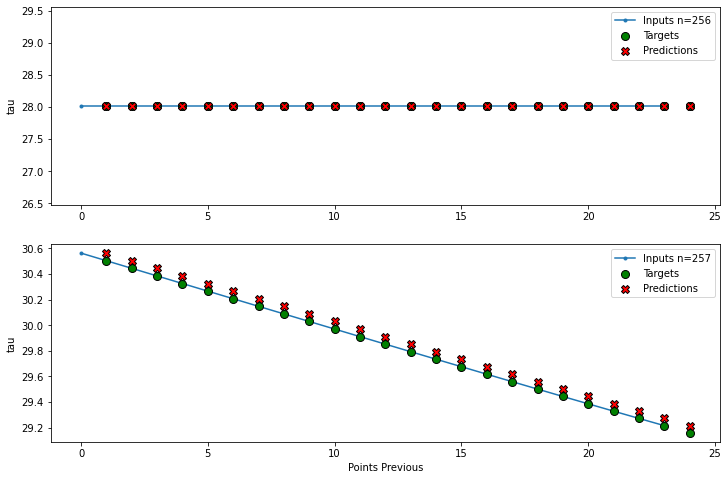

In [8]:
wide_window.plot(batch_size,model=baseline)

In [ ]:
# Build Model -- Linear Model
linear=Sequential(
    [layers.Dense(units=1)])

batch_size=512
single_step_window_train=single_step_window.make_dataset(train_df,batch_size)
single_step_window_val=single_step_window.make_dataset(val_df,batch_size)
single_step_window_test=single_step_window.make_dataset(test_df,batch_size)

max_epochs=20
def compile_and_fit(model, window_train,window_val,window_test, patience=2):
  early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
  model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[MeanAbsoluteError()])
  history=model.fit(window_train, epochs=max_epochs,
                    validation_data=window_val,
                    callbacks=[early_stopping])
  return history
history=compile_and_fit(linear,single_step_window_train,single_step_window_val,
                        single_step_window_test)

val_performance['Linear'] = linear.evaluate(single_step_window_val)
performance['Linear'] = linear.evaluate(single_step_window_test)


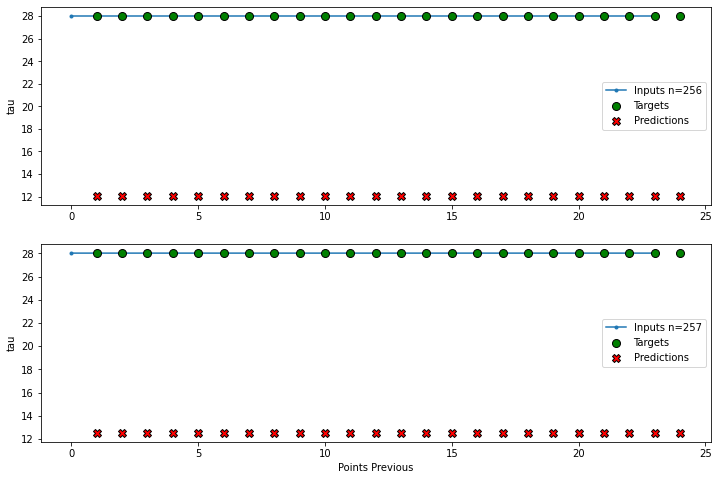

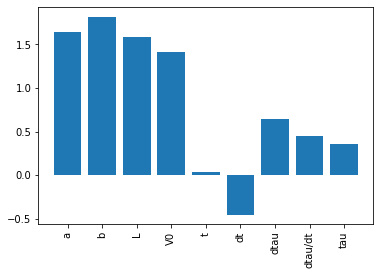

In [10]:
wide_window.plot(batch_size,model=linear)
plt.figure()
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
# Build Model -- Dense Model
dense=Sequential(
    [layers.Dense(units=218, activation='relu'),
     layers.Dense(units=64, activation='relu'),
     layers.Dense(units=1)])

history=compile_and_fit(dense, single_step_window_train,single_step_window_val,
                        single_step_window_test)
val_performance['Dense'] = dense.evaluate(single_step_window_val)
performance['Dense'] = dense.evaluate(single_step_window_test)

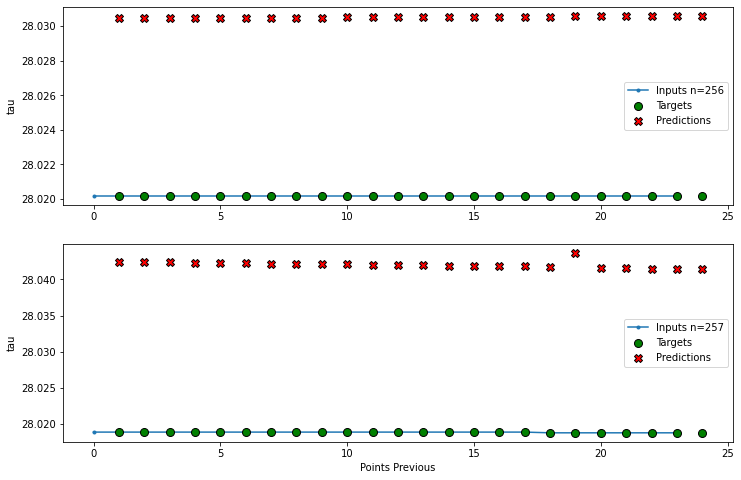

In [12]:
wide_window.plot(batch_size,model=dense)

In [18]:
# Build Model -- Multi-Step Dense -- conv_window
conv_window=WindowGenerator(
    input_width=5, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['tau']
)
print(conv_window)
#conv_window.plot(batch_size)
conv_window_train=conv_window.make_dataset(train_df,batch_size)
conv_window_val=conv_window.make_dataset(val_df,batch_size)
conv_window_test=conv_window.make_dataset(test_df,batch_size)

for example_inputs, example_labels in conv_window_train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['tau']
Inputs shape (batch, time, features): (512, 5, 9)
Labels shape (batch, time, features): (512, 1, 1)


In [ ]:
# Build Model -- Multi-Step Dense
multi_step_dense=Sequential(
    [#Shape:(time, features)-->(time*features)
     layers.Flatten(),
     layers.Dense(units=128, activation='relu'),
     layers.Dense(units=64, activation='relu'),
     layers.Dense(units=1),
     #Back the time dimension: Shape:(outputs)-->(1,outputs)
     layers.Reshape([1,-1])])

history = compile_and_fit(multi_step_dense, conv_window_train, conv_window_val,
                          conv_window_test)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window_val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window_test)

Input shape: (512, 24, 9)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 45, but received input with shape (512, 216)

Call arguments received:
  • inputs=tf.Tensor(shape=(512, 24, 9), dtype=float32)
  • training=None
  • mask=None


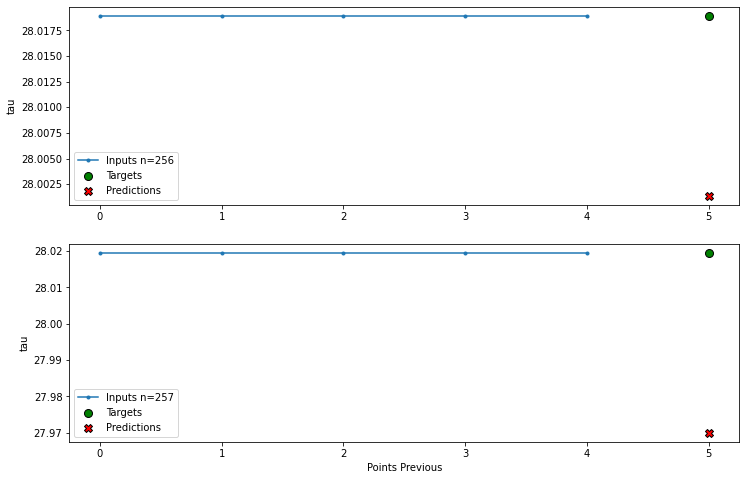

In [27]:
conv_window.plot(batch_size,model=multi_step_dense)

#for example_inputs, example_labels in conv_window_train.take(1):
print('Input shape:', wide_window_example_inputs.shape)
try:
  print('Output shape:', multi_step_dense(wide_window_example_inputs).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

In [ ]:
# Build Model -- Convolution Neural Network
conv_width=5 #==input_width
conv_model=Sequential(
    [layers.Conv1D(filters=32, kernel_size=(conv_width,), activation='relu'),
     layers.Dense(units=32, activation='relu'),
     layers.Dense(units=1)])
#print('Input shape:', example_inputs.shape)
#print('Output shape:', conv_model(example_inputs).shape)

history = compile_and_fit(conv_model, conv_window_train, conv_window_val,
                          conv_window_test)

val_performance['Conv'] = conv_model.evaluate(conv_window_val)
performance['Conv'] = conv_model.evaluate(conv_window_test)

Inputs shape (batch, time, features): (512, 24, 9)
Labels shape (batch, time, features): (512, 24, 1)
Wide window
Input shape: (512, 24, 9)
Labels shape: (512, 24, 1)
Output shape: (512, 20, 1)


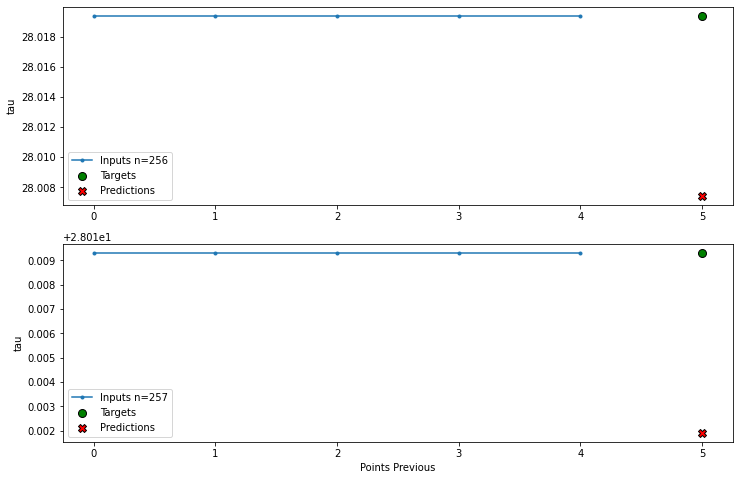

In [29]:
conv_window.plot(batch_size,model=conv_model)
for wide_window_example_inputs, wide_window_example_labels in wide_window_train.take(1):
  print(f'Inputs shape (batch, time, features): {wide_window_example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {wide_window_example_labels.shape}')
print("Wide window")
print('Input shape:', wide_window_example_inputs.shape)
print('Labels shape:', wide_window_example_labels.shape)
print('Output shape:', conv_model(wide_window_example_inputs).shape)

Wide window
Input shape: (512, 24, 9)
Labels shape: (512, 24, 1)
Output shape: (512, 20, 1)
Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Label column name(s): ['tau']
Wide conv window
Input shape: (512, 28, 9)
Labels shape: (512, 24, 1)
Output shape: (512, 24, 1)


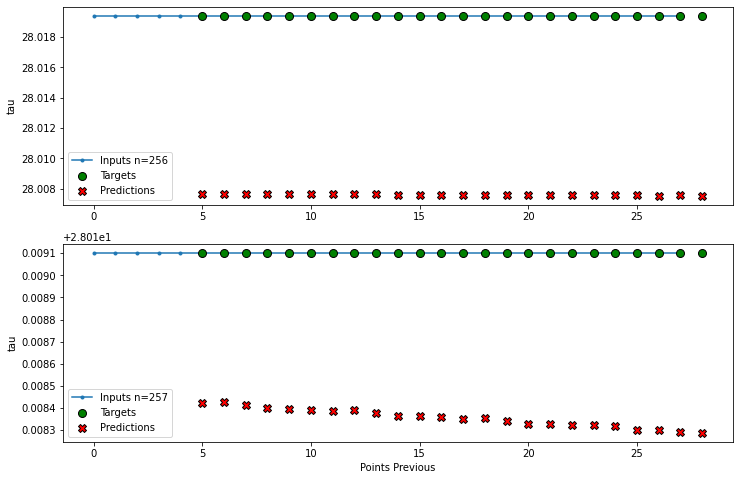

In [33]:
print("Wide window")
print('Input shape:', wide_window_example_inputs.shape)
print('Labels shape:', wide_window_example_labels.shape)
print('Output shape:', conv_model(wide_window_example_inputs).shape)
# For CNN: Wide_Conv_Window
label_width=24
input_width=label_width+(conv_width-1)
wide_conv_window=WindowGenerator(
    input_width=input_width, label_width=label_width, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['tau'])
print(wide_conv_window)
wide_conv_window_train=wide_conv_window.make_dataset(train_df,batch_size)
wide_conv_window_val=wide_conv_window.make_dataset(val_df,batch_size)
wide_conv_window_test=wide_conv_window.make_dataset(test_df,batch_size)
for wide_conv_window_example_inputs, wide_conv_window_example_labels in wide_conv_window_train.take(1):
  print("Wide conv window")
  print('Input shape:', wide_conv_window_example_inputs.shape)
  print('Labels shape:', wide_conv_window_example_labels.shape)
  print('Output shape:', conv_model(wide_conv_window_example_inputs).shape)
wide_conv_window.plot(batch_size,model=conv_model)

In [ ]:
# Build Model -- RNN LSTM
lstm_model=Sequential(
    [#Shape [batch,time,features]-->[batch,time,lstm_units]
     layers.LSTM(32, return_sequences=True),
     #Shape [batch,time,features]
     layers.Dense(units=1)])

history = compile_and_fit(lstm_model, wide_window_train, wide_window_val,
                          wide_window_test)

val_performance['LSTM'] = lstm_model.evaluate(wide_window_val)
performance['LSTM'] = lstm_model.evaluate(wide_window_test)

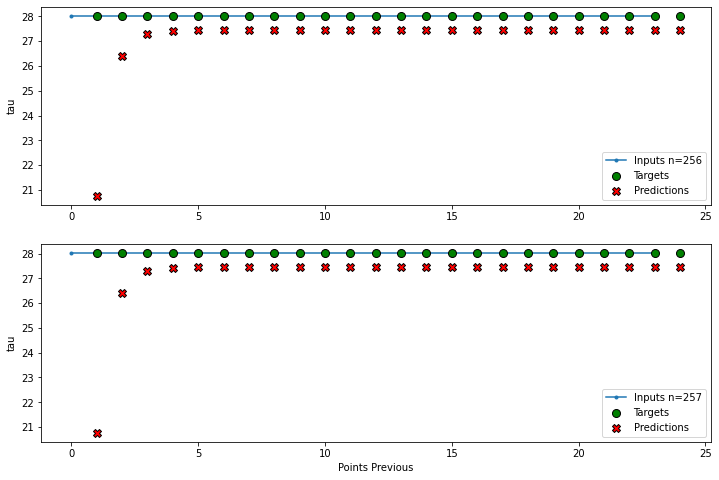

In [35]:
wide_window.plot(batch_size=batch_size,model=lstm_model)

In [44]:
# Performances
#print(val_performance)
#print(performance)
print('val_loss')
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

#x = np.arange(len(performance))
#width = 0.3
#metric_name = 'mean_absolute_error'
#metric_index = lstm_model.metrics_names.index('mean_absolute_error')
#val_mae = [v[metric_index] for v in val_performance.values()]
#test_mae = [v[metric_index] for v in performance.values()]
#plt.ylabel('mean_absolute_error [tau]')
#plt.bar(x - 0.17, val_mae, width, label='Validation')
#plt.bar(x + 0.17, test_mae, width, label='Test')
#plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
#_ = plt.legend()

val_loss
Baseline    : 0.0020
Linear      : 15.0723
Dense       : 0.0268
Multi step dense: 0.0660
Conv        : 0.0359
LSTM        : 1.2125


### SKIP MULTI-OUTPUTS, i.e. label_columns=None
### Build Model -- Multi-Step Model -- To make multiple time step predictions
##### 1. label_columns=['tau']
##### 2. NEED another try: label_columns=None, i.e., take all prediction features as inputs in autoregressive LSTM/ or in single shot models

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['tau']


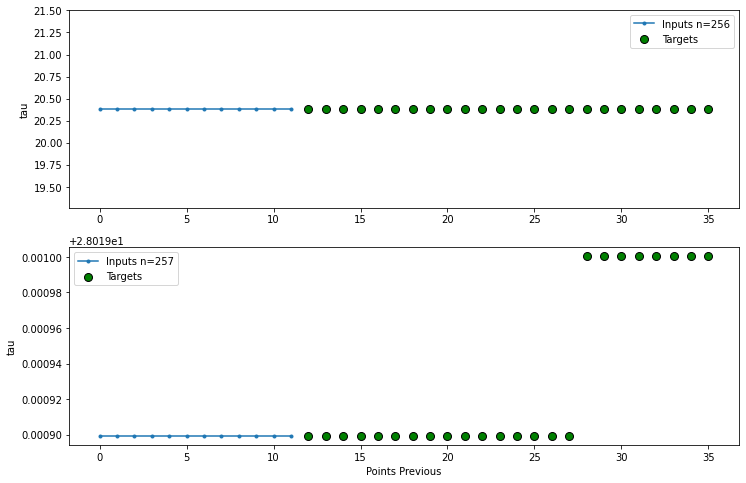

In [91]:
# multi_window
out_step=24
multi_window=WindowGenerator(input_width=12, label_width=out_step, shift=out_step,
                             train_df=train_df, val_df=val_df, test_df=test_df,
                             label_columns=['tau'])
print(multi_window)
multi_window.plot(batch_size)
multi_window_train=multi_window.make_dataset(train_df,batch_size)
multi_window_val=multi_window.make_dataset(val_df,batch_size)
multi_window_test=multi_window.make_dataset(test_df,batch_size)

20/20 [==============================] - 1s 32ms/step - loss: 3442.4004 - mean_absolute_error: 26.4741


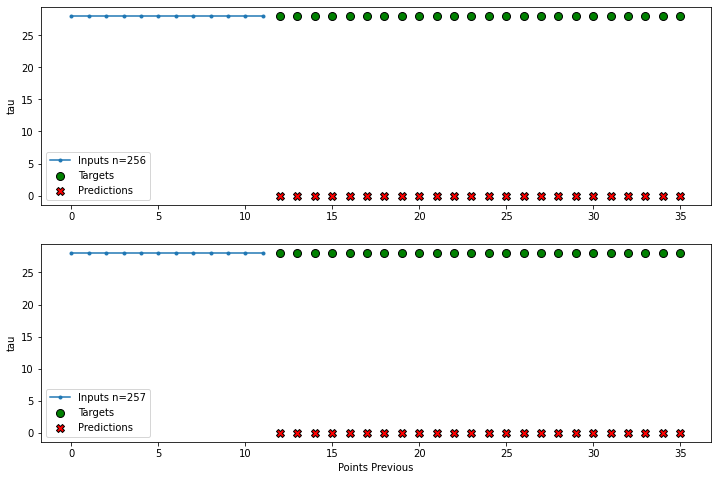

In [92]:
# Make Baseline Model
class MultiStepLastBaseline(Model):
  def call(self, inputs):
    #repeat the last point out_step times
    return tf.tile(inputs[:,-1:,:], [1,out_step,1])

last_baseline=MultiStepLastBaseline()
last_baseline.compile(loss=MeanSquaredError(),
                      metrics=[MeanAbsoluteError()])
multi_val_performance={}
multi_performance={}
multi_val_performance['Last']=last_baseline.evaluate(multi_window_val)
multi_performance['Last']=last_baseline.evaluate(multi_window_test)
multi_window.plot(batch_size=batch_size,model=last_baseline)

Epoch 1/20
60/60 [==============================] - 8s 109ms/step - loss: 650.2718 - mean_absolute_error: 25.0146 - val_loss: 590.6189 - val_mean_absolute_error: 23.8406
Epoch 2/20
60/60 [==============================] - 7s 108ms/step - loss: 547.8837 - mean_absolute_error: 23.0065 - val_loss: 519.1929 - val_mean_absolute_error: 22.4081
Epoch 3/20
60/60 [==============================] - 7s 105ms/step - loss: 481.4031 - mean_absolute_error: 21.5753 - val_loss: 454.9359 - val_mean_absolute_error: 20.9853
Epoch 4/20
60/60 [==============================] - 7s 108ms/step - loss: 420.6593 - mean_absolute_error: 20.1595 - val_loss: 396.3755 - val_mean_absolute_error: 19.5867
Epoch 5/20
60/60 [==============================] - 7s 103ms/step - loss: 365.5972 - mean_absolute_error: 18.8002 - val_loss: 343.5545 - val_mean_absolute_error: 18.2419
Epoch 6/20
60/60 [==============================] - 7s 105ms/step - loss: 316.0240 - mean_absolute_error: 17.4737 - val_loss: 296.1473 - val_mean_abso

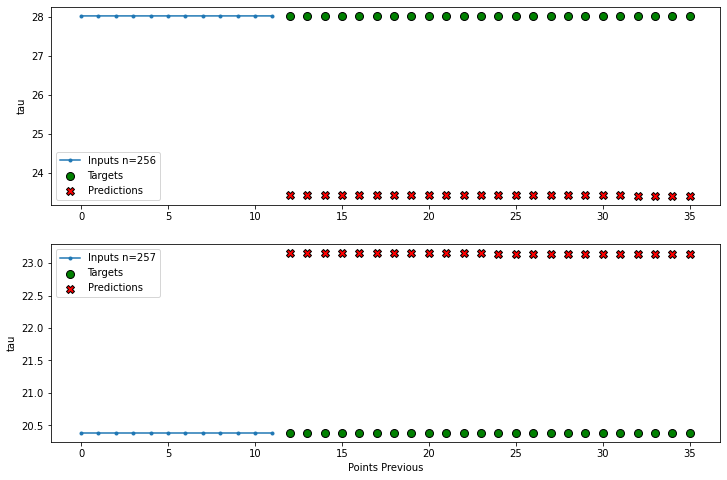

In [93]:
# Build Model -- Single Shot Model
# Linear
num_features=train_df.shape[1]
#### HAVE QUESTIONS HERE
multi_linear_model=Sequential(
    [#Take the last time-step
     #Shape [batch,time,features]-->[batch,1,features]
     layers.Lambda(lambda x: x[:,-1:,:]),
     #Shape [batch,1,out_step*features]
     layers.Dense(out_step*num_features,
                  kernel_initializer=tf.initializers.zeros()),
     #Shape [batch,out_step,features]
     layers.Reshape([out_step, num_features])])

history = compile_and_fit(multi_linear_model, multi_window_train,
                          multi_window_val, multi_window_test)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window_val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window_test)
multi_window.plot(batch_size=batch_size,model=multi_linear_model)

In [ ]:
# Build Model -- Single Shot Model -- Dense
multi_dense_model=Sequential(
    [#Shape [batch,time,features]-->[batch,1,features]
     layers.Lambda(lambda x: x[:,-1:,:]),
     #Shape-->[batch,1,dense_units]
     layers.Dense(units=512, activation='relu'),
     #Shape-->[batch,out_step*features]
     layers.Dense(units=out_step*num_features, 
                  kernel_initializer=tf.initializers.zeros()),
     #Shape-->[batch,out_step,features]
     layers.Reshape([out_step, num_features])])

history=compile_and_fit(multi_dense_model, multi_window_train,
                        multi_window_val, multi_window_test)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window_val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window_test)

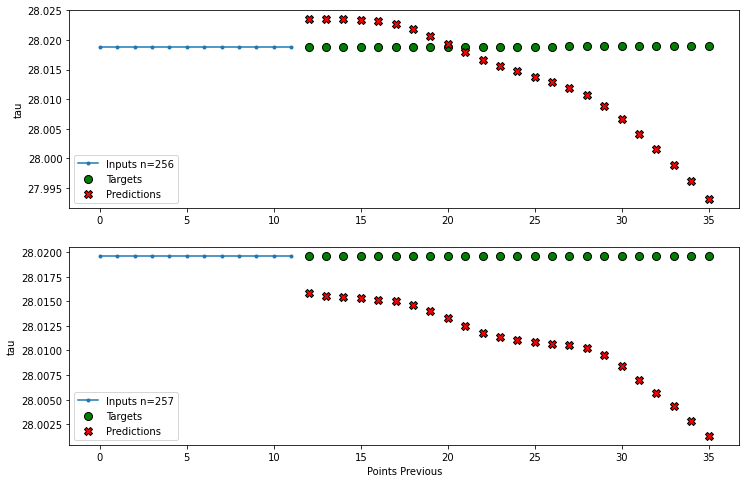

In [95]:
multi_window.plot(batch_size=batch_size,model=multi_dense_model)

Epoch 1/20
60/60 [==============================] - 8s 114ms/step - loss: 236.5250 - mean_absolute_error: 11.8909 - val_loss: 1.3568 - val_mean_absolute_error: 0.8523
Epoch 2/20
60/60 [==============================] - 4s 62ms/step - loss: 0.7256 - mean_absolute_error: 0.5263 - val_loss: 0.2484 - val_mean_absolute_error: 0.1828
Epoch 3/20
60/60 [==============================] - 4s 64ms/step - loss: 0.1606 - mean_absolute_error: 0.1406 - val_loss: 0.1067 - val_mean_absolute_error: 0.0897
Epoch 4/20
60/60 [==============================] - 5s 73ms/step - loss: 0.1007 - mean_absolute_error: 0.0869 - val_loss: 0.0983 - val_mean_absolute_error: 0.0872
Epoch 5/20
60/60 [==============================] - 4s 68ms/step - loss: 0.0891 - mean_absolute_error: 0.0725 - val_loss: 0.0863 - val_mean_absolute_error: 0.0695
Epoch 6/20
60/60 [==============================] - 4s 66ms/step - loss: 0.0828 - mean_absolute_error: 0.0659 - val_loss: 0.0779 - val_mean_absolute_error: 0.0579
Epoch 7/20
60/60 [

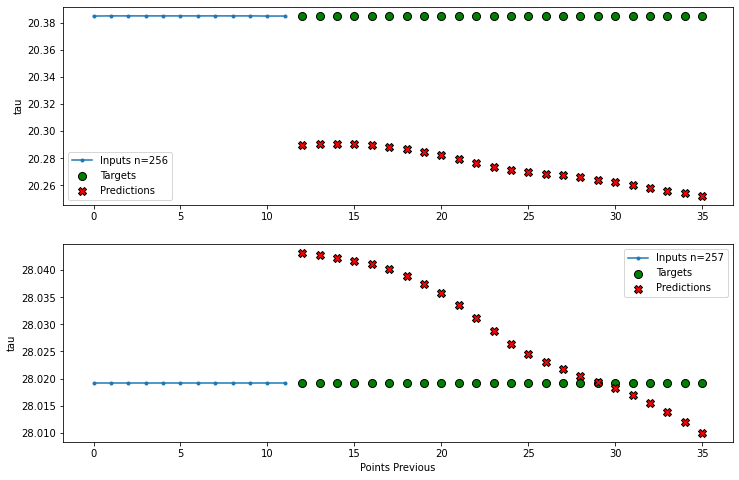

In [98]:
# Build Model -- Single Shot Model -- CNN
conv_width=3
multi_conv_model=Sequential(
    [#Shape [batch,time,features]-->[batch,conv_width,features]
     layers.Lambda(lambda x: x[:,-conv_width:,:]),
     #Shape-->[batch,1,conv_units]
     layers.Conv1D(filters=256, activation='relu', kernel_size=(conv_width,)),
     #Shape-->[batch,1,out_step*features]
     layers.Dense(units=out_step*num_features,
                  kernel_initializer=tf.initializers.zeros()),
     #Shape-->[batch,out_step,features]
     layers.Reshape([out_step, num_features])])

history = compile_and_fit(multi_conv_model, multi_window_train,
                          multi_window_val, multi_window_test)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window_val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window_test)
multi_window.plot(batch_size=batch_size,model=multi_conv_model)


Epoch 1/20
60/60 [==============================] - 13s 133ms/step - loss: 711.7160 - mean_absolute_error: 26.5685 - val_loss: 660.6143 - val_mean_absolute_error: 25.6187
Epoch 2/20
60/60 [==============================] - 7s 108ms/step - loss: 575.3737 - mean_absolute_error: 23.8722 - val_loss: 520.5697 - val_mean_absolute_error: 22.7405
Epoch 3/20
60/60 [==============================] - 7s 111ms/step - loss: 466.8212 - mean_absolute_error: 21.5010 - val_loss: 429.2029 - val_mean_absolute_error: 20.6334
Epoch 4/20
60/60 [==============================] - 7s 110ms/step - loss: 383.7729 - mean_absolute_error: 19.4706 - val_loss: 352.4463 - val_mean_absolute_error: 18.6652
Epoch 5/20
60/60 [==============================] - 8s 122ms/step - loss: 313.9830 - mean_absolute_error: 17.5756 - val_loss: 288.5873 - val_mean_absolute_error: 16.8538
Epoch 6/20
60/60 [==============================] - 7s 109ms/step - loss: 255.4922 - mean_absolute_error: 15.8022 - val_loss: 234.4190 - val_mean_abs

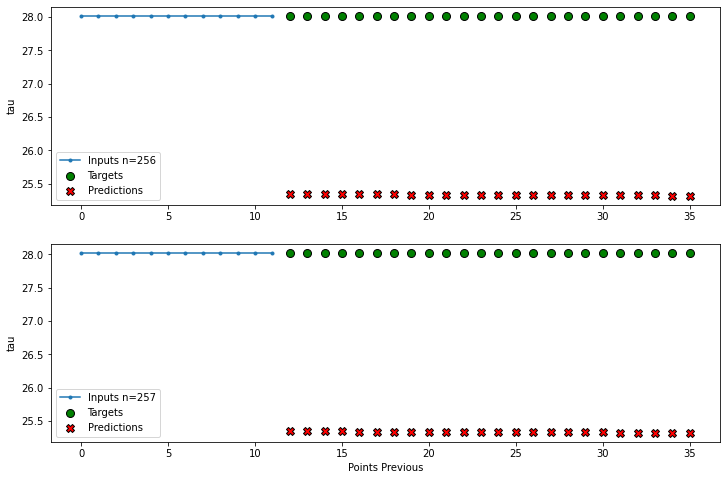

In [99]:
# Build Model -- Single Shot Model -- RNN
multi_lstm_model=Sequential(
    [#Shape[batch,time,features]-->[batch,lstm_units]
     #Add lstm units cause more quickly overfitting
     layers.LSTM(32, return_sequences=False),
     #Shape-->[batch,out_step*features]
     layers.Dense(units=out_step*num_features,
                  kernel_initializer=tf.initializers.zeros()),
     #Shape-->[batch,out_step,features]
     layers.Reshape([out_step,num_features])])

history=compile_and_fit(multi_lstm_model, multi_window_train,
                        multi_window_val, multi_window_test)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_test)
multi_window.plot(batch_size=batch_size,model=multi_lstm_model)

(512, 9)
(512, 24, 9)
Epoch 1/20
60/60 [==============================] - 20s 180ms/step - loss: 681.7548 - mean_absolute_error: 25.9627 - val_loss: 594.3732 - val_mean_absolute_error: 24.2600
Epoch 2/20
60/60 [==============================] - 10s 153ms/step - loss: 520.7869 - mean_absolute_error: 22.6604 - val_loss: 471.2888 - val_mean_absolute_error: 21.5718
Epoch 3/20
60/60 [==============================] - 6s 101ms/step - loss: 420.8367 - mean_absolute_error: 20.3511 - val_loss: 385.6292 - val_mean_absolute_error: 19.4842
Epoch 4/20
60/60 [==============================] - 6s 102ms/step - loss: 344.2267 - mean_absolute_error: 18.3732 - val_loss: 316.2479 - val_mean_absolute_error: 17.6188
Epoch 5/20
60/60 [==============================] - 7s 105ms/step - loss: 281.3719 - mean_absolute_error: 16.5769 - val_loss: 258.3533 - val_mean_absolute_error: 15.8922
Epoch 6/20
60/60 [==============================] - 7s 103ms/step - loss: 228.5661 - mean_absolute_error: 14.9061 - val_loss: 

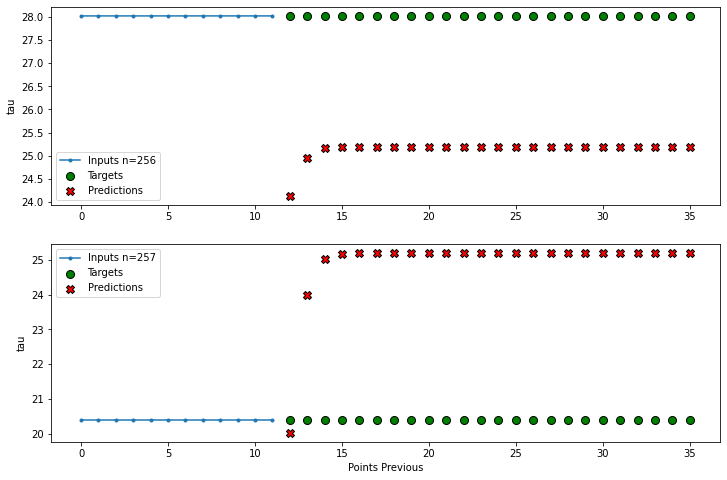

In [109]:
# Build Model -- AutoRegressive Model -- RNN
class FeedBack(Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps=out_steps
    self.units=units
    self.lstm_cell=layers.LSTMCell(units)
    #Wrap the LSTMCell in RNN to simplify the warmup method
    self.lstm_rnn=layers.RNN(self.lstm_cell, return_state=True)
    self.dense=layers.Dense(num_features)

  def warmup(self, inputs):
    #input.shape-->(batch,time,features)
    #x.shape-->(batch,lstm_units)
    x, *state=self.lstm_rnn(inputs)
    #prediction.shape-->(batch,features)
    prediction=self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    predictions=[] #TensorArray
    prediction, state=self.warmup(inputs) #initialize
    predictions.append(prediction)
    for n in range(1, self.out_steps):
      x=prediction #Use the last prediction as input
      x, state=self.lstm_cell(x, states=state, training=training)
      prediction=self.dense(x)
      predictions.append(prediction)
    #predictions.shape-->(time,batch,features)
    predictions=tf.stack(predictions)
    #predictions.shape-->(batch,time,features)
    predictions=tf.transpose(predictions,[1,0,2])
    return predictions

feedback_model = FeedBack(units=32, out_steps=out_step)
for multi_window_example_input, multi_window_example_label in multi_window_train.take(1):
  prediction, state=feedback_model.warmup(multi_window_example_input)
  print(prediction.shape)
  print(feedback_model(multi_window_example_input).shape)


history = compile_and_fit(feedback_model, multi_window_train,
                          multi_window_val, multi_window_test)

multi_val_performance['AutoRegressive LSTM'] = feedback_model.evaluate(multi_window_val)
multi_performance['AutoRegressive LSTM'] = feedback_model.evaluate(multi_window_test)
multi_window.plot(batch_size=batch_size,model=feedback_model)

In [111]:
print('test_loss mae')
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

test_loss mae
Last    : 26.4741
Linear  : 4.2601
Dense   : 0.0473
Conv    : 0.0398
LSTM    : 2.9197
AutoRegressive LSTM: 2.6710


In [ ]:
# Repeat Baseline 
# Only useful when out_step==input_width
class RepeatBaseline(Model):
  def call(self, inputs):
    return inputs
repeat_baseline=RepeatBaseline()
repeat_baseline.compile(loss=MeanSquaredError(),
                        metrics=[MeanAbsoluteError()])

multi_val_performance['Repeat']=repeat_baseline.evaluate(multi_window_val)
multi_performance['Repeat']=repeat_baseline.evaluate(multi_window_test)
multi_window.plot(batch_size=batch_size, model=repeat_baseline)
